In [2]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import pandas as pd
from glob import glob
from torch.utils.data import Dataset, DataLoader
from PIL import Image

In [3]:
# run params
section = 'vae'
run_id = '0001'
data_name = 'faces'
RUN_FOLDER = 'run/{}/'.format(section)
RUN_FOLDER += '_'.join([run_id, data_name])


DATA_FOLDER = './data/celeb/'
IMAGE_FOLDER = './data/celeb/img_align_celeba/'

In [4]:
att = pd.read_csv(os.path.join(DATA_FOLDER, 'list_attr_celeba.csv'))
att.head()

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


In [5]:
NUM_CLASSES = 10
BATCH_SIZE = 32
transform = transforms.Compose([   
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])
filenames = np.array(glob(os.path.join(DATA_FOLDER, '*/*.jpg')))
NUM_IMAGES = len(filenames)


class SimpleDataset(Dataset):
    def __init__(self, filenames, transform):
        self.filenames = filenames
        self.transform = transform

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        img = Image.open(self.filenames[idx])
        if self.transform:
            img = self.transform(img)
        return img

dataset = SimpleDataset(filenames, transform)
dataloader = DataLoader(dataset, BATCH_SIZE)

In [6]:
dataset = SimpleDataset(filenames, transform)
dataloader = DataLoader(dataset, BATCH_SIZE)
z_dim = 200
device = 'cpu'

In [7]:
class Encoder(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 2)
        self.bn1 = nn.BatchNorm2d(32)
        self.dropout1 = nn.Dropout()

        self.conv2 = nn.Conv2d(32, 64, 3, 2)
        self.bn2 = nn.BatchNorm2d(64)
        self.dropout2 = nn.Dropout()

        self.conv3 = nn.Conv2d(64, 64, 3, 2)
        self.bn3 = nn.BatchNorm2d(64)
        self.dropout3 = nn.Dropout()

        self.conv4 = nn.Conv2d(64, 64, 3, 2)
        self.bn4 = nn.BatchNorm2d(64)
        self.dropout4 = nn.Dropout()

        self.flatten = nn.Flatten()
        self.mu = nn.Linear(4096, z_dim)

        self.log_var = nn.Linear(4096, z_dim)

    def forward(self, x):
        x = F.pad(self.conv1(x), (1,0,1,0))
        x = self.bn1(x)
        x = F.leaky_relu(x)
        x = self.dropout1(x)

        x = F.pad(self.conv2(x), (1,0,1,0))
        x = self.bn2(x)
        x = F.leaky_relu(x)
        x = self.dropout2(x)

        x = F.pad(self.conv3(x), (1,0,1,0))
        x = self.bn3(x)
        x = F.leaky_relu(x)
        x = self.dropout3(x)

        x = F.pad(self.conv4(x), (1,0,1,0))
        x = self.bn4(x)
        x = F.leaky_relu(x)
        x = self.dropout4(x)

        x = self.flatten(x)

        mu, log_var = self.mu(x), self.log_var(x)

        def sampling(args):
            mu, log_var = args
            epsilon = torch.normal(0., 1., size=mu.shape).to(device)
            return mu + torch.exp(log_var / 2) * epsilon

        x = sampling([mu, log_var])

        return x, mu, log_var


In [8]:
class Decoder(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.linear1 = nn.Linear(z_dim, 64*6*6)

        self.convT1 = nn.ConvTranspose2d(64, 64, 3, 2, 1)
        self.bn1 = nn.BatchNorm2d(64)
        self.dropout1 = nn.Dropout()

        self.convT2 = nn.ConvTranspose2d(64, 64, 3, 2, 1)
        self.bn2 = nn.BatchNorm2d(64)
        self.dropout2 = nn.Dropout()

        self.convT3 = nn.ConvTranspose2d(64, 32, 3, 2, 1)
        self.bn3 = nn.BatchNorm2d(32)
        self.dropout3 = nn.Dropout()

        self.convT4 = nn.ConvTranspose2d(32, 3, 3, 2)

    def forward(self, x):
        x = self.linear1(x)
        x = x.reshape(-1, 64, 6, 6)

        x = F.pad(self.convT1(x), (2,1,2,1))      
        x = self.bn1(x)
        x = F.leaky_relu(x)
        x = self.dropout1(x)

        x = F.pad(self.convT2(x), (2,1,2,1))      
        x = self.bn2(x)
        x = F.leaky_relu(x)
        x = self.dropout2(x)

        x = F.pad(self.convT3(x), (2,1,2,1))      
        x = self.bn3(x)
        x = F.leaky_relu(x)
        x = self.dropout3(x)

        x = F.pad(self.convT4(x), (2,1,2,1)) 
        
        return torch.sigmoid(x)


In [9]:
class AutoEncoder(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.encoder = Encoder().to(device)
        self.decoder = Decoder().to(device)
    def forward(self, x):
        t, mu, log_var = self.encoder(x)
        x = self.decoder(t)
        return x, t, mu, log_var

In [10]:
model = torch.load(RUN_FOLDER + '/weights/weight.pt').cpu()

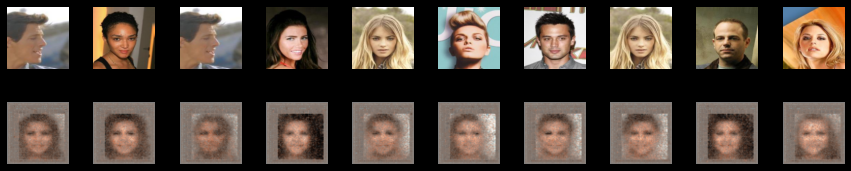

In [11]:
with torch.no_grad():
    transform1 = transforms.ToPILImage()

    n_to_show = 10
    images = next(iter(dataloader))

    example_idx = np.random.choice(range(len(images)), n_to_show)
    example_images = images[example_idx]

    z_points, _, _ = model.encoder(example_images)

    reconst_images = model.decoder(z_points)

    fig = plt.figure(figsize=(15, 3))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)

    for i in range(n_to_show):
        img = transform1(example_images[i].squeeze())
        sub = fig.add_subplot(2, n_to_show, i+1)
        sub.axis('off')        
        sub.imshow(img)

    for i in range(n_to_show):
        img = transform1(reconst_images[i].squeeze())
        sub = fig.add_subplot(2, n_to_show, i+n_to_show+1)
        sub.axis('off')
        sub.imshow(img)


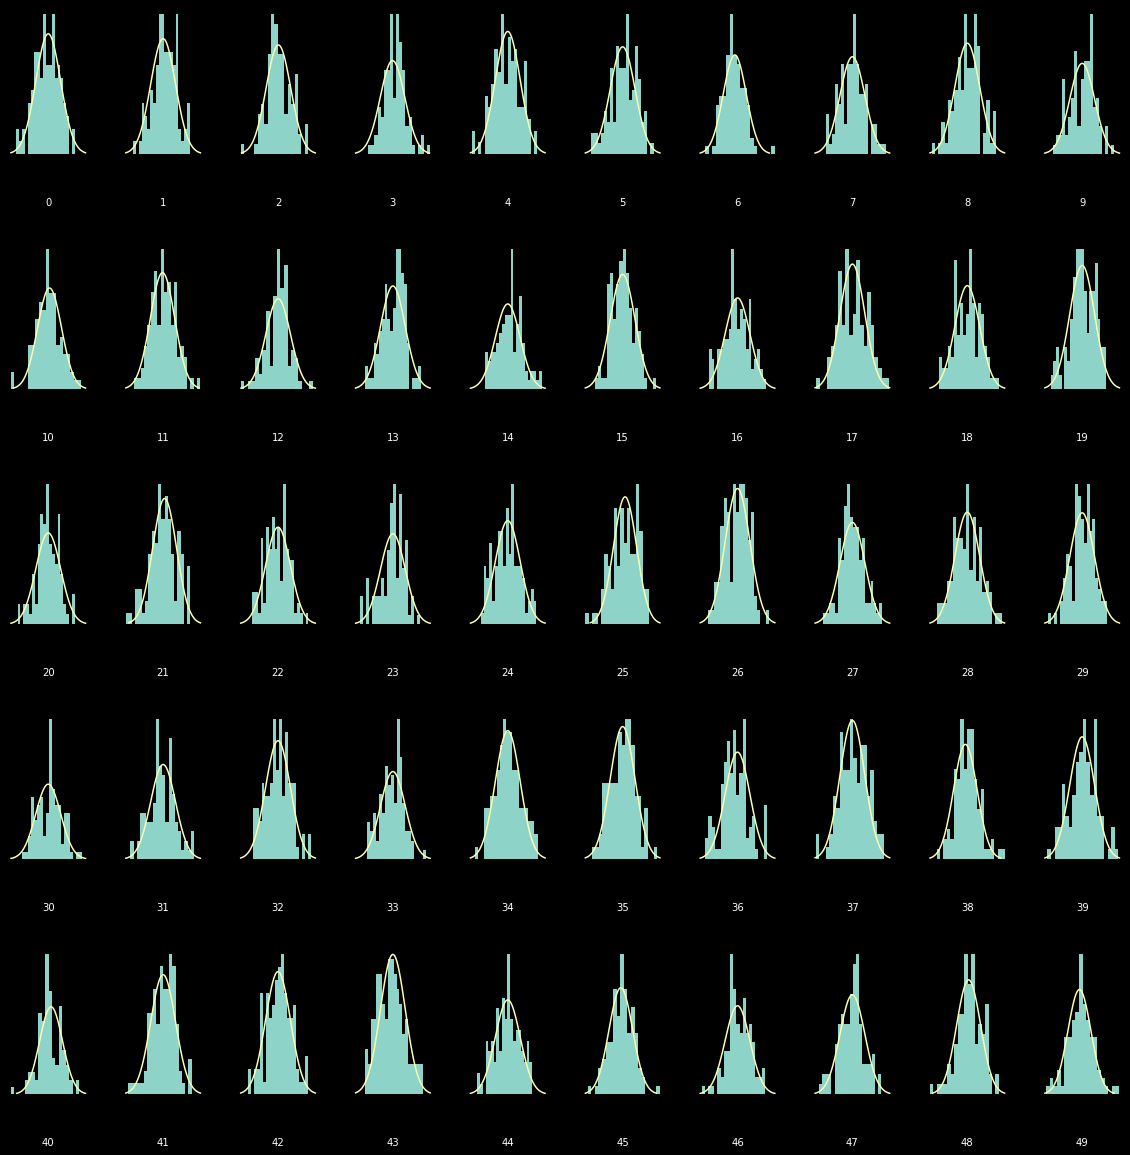

In [14]:
with torch.no_grad():
    dataloader = DataLoader(dataset, 100)
    inputs = next(iter(dataloader))
    z_test, _, _ =model.encoder(inputs)

    z_test = z_test.numpy()

    x = np.linspace(-3, 3, 100)

    fig = plt.figure(figsize=(20, 20))
    fig.subplots_adjust(hspace=0.6, wspace=0.4)

    for i in range(50):
        ax = fig.add_subplot(5, 10, i+1)
        ax.hist(z_test[:,i], density=True, bins = 20)
        ax.axis('off')
        ax.text(0.5, -0.35, str(i), fontsize=10, ha='center', transform=ax.transAxes)
        ax.plot(x,norm.pdf(x))

    plt.show()

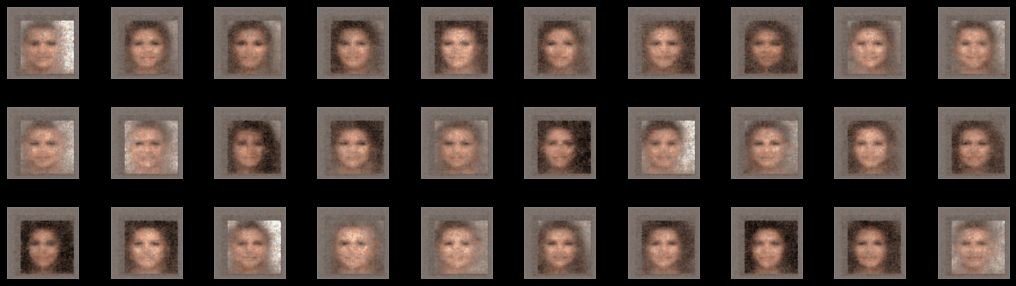

In [29]:
with torch.no_grad():
    transform1 = transforms.ToPILImage()
    n_to_show = 30
    znew = np.random.normal(size = (n_to_show,200))
    znew = np.array(znew, dtype=np.float32)

    reconst = model.decoder(torch.from_numpy(znew))

    fig = plt.figure(figsize=(18, 5))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    for i in range(n_to_show):
        ax = fig.add_subplot(3, 10, i+1)
        img = transform1(reconst[i, :,:,:])
        ax.imshow(img)
        ax.axis('off')

    plt.show()

In [53]:
class SimpleDataset(Dataset):
    def __init__(self, dataframe, transform):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img = Image.open(f"{DATA_FOLDER}/img_align_celeba/{self.dataframe.iloc[idx][0]}")
        label = torch.tensor(self.dataframe.iloc[idx][1:])
        if self.transform:
            img = self.transform(img)
        return img, label
att = pd.read_csv(os.path.join(DATA_FOLDER, 'list_attr_celeba.csv'))
dataset = SimpleDataset(att, transform)
dataloader = DataLoader(dataset, BATCH_SIZE)

In [68]:
torch.tensor(att.iloc[0][1:]).shape

torch.Size([40])

In [80]:
next(iter(dataloader))[1].numpy()[:,1]

array([ 1, -1, -1, -1,  1,  1, -1,  1,  1, -1, -1, -1, -1,  1, -1, -1, -1,
        1,  1, -1, -1,  1, -1,  1, -1, -1,  1, -1,  1, -1, -1, -1, -1,  1,
        1, -1, -1, -1,  1, -1, -1,  1,  1, -1,  1, -1,  1, -1, -1, -1, -1,
       -1, -1,  1, -1,  1,  1,  1, -1, -1, -1, -1,  1, -1, -1,  1, -1, -1,
       -1, -1, -1, -1, -1,  1,  1, -1, -1,  1, -1, -1, -1, -1,  1, -1,  1,
        1,  1, -1, -1, -1, -1, -1, -1,  1, -1, -1,  1,  1, -1, -1,  1, -1,
        1, -1, -1, -1, -1,  1, -1, -1, -1, -1, -1, -1, -1, -1,  1, -1, -1,
       -1, -1,  1, -1, -1, -1,  1, -1,  1, -1, -1, -1,  1,  1, -1, -1, -1,
       -1, -1, -1,  1,  1,  1, -1, -1, -1, -1,  1,  1, -1, -1,  1, -1, -1,
       -1,  1, -1, -1, -1, -1, -1,  1,  1, -1, -1,  1, -1, -1,  1, -1, -1,
       -1, -1, -1,  1, -1, -1,  1, -1, -1, -1, -1, -1,  1, -1,  1, -1, -1,
       -1, -1,  1, -1, -1, -1, -1, -1,  1, -1,  1, -1, -1,  1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1, -1, -1, -1,  1, -1,
        1, -1, -1,  1, -1

In [87]:
def get_vector_from_label(label, batch_size):
    column_arr = np.array(att.columns)[1:]
    index = np.where(column_arr == label)

    dataloader = DataLoader(dataset, batch_size)

    origin = np.zeros(shape = 200, dtype = 'float32')
    current_sum_POS = np.zeros(shape = 200, dtype = 'float32')
    current_n_POS = 0
    current_mean_POS = np.zeros(shape = 200, dtype = 'float32')

    current_sum_NEG = np.zeros(shape = 200, dtype = 'float32')
    current_n_NEG = 0
    current_mean_NEG = np.zeros(shape = 200, dtype = 'float32')

    current_vector = np.zeros(shape = 200, dtype = 'float32')
    current_dist = 0

    print('label: ' + label)
    print('images : POS move : NEG move :distance : 𝛥 distance')
    while(current_n_POS < 10000):

        batch = next(iter(dataloader))
        im = batch[0].numpy()
        im = np.array(im, dtype=np.float32)

        attribute = batch[1].numpy()[:,index].reshape(batch_size)

        with torch.no_grad():
            z, _, _ = model.encoder(torch.tensor(im))
        z = z.numpy()
        # print(z.shape, attrib/ute.shape)

        z_POS = z[attribute==1]
        z_NEG = z[attribute==-1]

        if len(z_POS) > 0:
            current_sum_POS = current_sum_POS + np.sum(z_POS, axis = 0)
            current_n_POS += len(z_POS)
            new_mean_POS = current_sum_POS / current_n_POS
            movement_POS = np.linalg.norm(new_mean_POS-current_mean_POS)

        if len(z_NEG) > 0: 
            current_sum_NEG = current_sum_NEG + np.sum(z_NEG, axis = 0)
            current_n_NEG += len(z_NEG)
            new_mean_NEG = current_sum_NEG / current_n_NEG
            movement_NEG = np.linalg.norm(new_mean_NEG-current_mean_NEG)

        current_vector = new_mean_POS-new_mean_NEG
        new_dist = np.linalg.norm(current_vector)
        dist_change = new_dist - current_dist


        print(str(current_n_POS)
              + '    : ' + str(np.round(movement_POS,3))
              + '    : ' + str(np.round(movement_NEG,3))
              + '    : ' + str(np.round(new_dist,3))
              + '    : ' + str(np.round(dist_change,3))
             )

        current_mean_POS = np.copy(new_mean_POS)
        current_mean_NEG = np.copy(new_mean_NEG)
        current_dist = np.copy(new_dist)

        if np.sum([movement_POS, movement_NEG]) < 0.08:
            current_vector = current_vector / current_dist
            print('Found the ' + label + ' vector')
            break

    return current_vector   


In [88]:
BATCH_SIZE = 500
attractive_vec = get_vector_from_label('Attractive', BATCH_SIZE)
mouth_open_vec = get_vector_from_label('Mouth_Slightly_Open', BATCH_SIZE)
smiling_vec = get_vector_from_label('Smiling', BATCH_SIZE)
lipstick_vec = get_vector_from_label('Wearing_Lipstick', BATCH_SIZE)
young_vec = get_vector_from_label('High_Cheekbones', BATCH_SIZE)
male_vec = get_vector_from_label('Male', BATCH_SIZE)

label: Attractive
images : POS move : NEG move :distance : 𝛥 distance
262    : 0.847    : 0.96    : 1.277    : 1.277
524    : 0.585    : 0.663    : 0.907    : -0.371
786    : 0.382    : 0.377    : 0.763    : -0.144
1048    : 0.257    : 0.231    : 0.684    : -0.08
1310    : 0.198    : 0.223    : 0.636    : -0.048
1572    : 0.162    : 0.181    : 0.572    : -0.065
1834    : 0.135    : 0.155    : 0.532    : -0.039
2096    : 0.113    : 0.122    : 0.501    : -0.031
2358    : 0.095    : 0.108    : 0.486    : -0.015
2620    : 0.089    : 0.096    : 0.458    : -0.027
2882    : 0.079    : 0.094    : 0.443    : -0.015
3144    : 0.078    : 0.085    : 0.422    : -0.021
3406    : 0.072    : 0.067    : 0.415    : -0.007
3668    : 0.065    : 0.066    : 0.395    : -0.02
3930    : 0.06    : 0.064    : 0.383    : -0.012
4192    : 0.057    : 0.059    : 0.375    : -0.008
4454    : 0.053    : 0.056    : 0.375    : 0.0
4716    : 0.046    : 0.053    : 0.377    : 0.002
4978    : 0.05    : 0.048    : 0.373    : 

In [89]:
eyeglasses_vec = get_vector_from_label('Eyeglasses', BATCH_SIZE)

label: Eyeglasses
images : POS move : NEG move :distance : 𝛥 distance
31    : 2.493    : 0.677    : 2.621    : 2.621
62    : 1.776    : 0.491    : 1.888    : -0.733
93    : 1.045    : 0.274    : 1.536    : -0.352
124    : 0.707    : 0.181    : 1.367    : -0.17
155    : 0.561    : 0.125    : 1.237    : -0.129
186    : 0.425    : 0.105    : 1.129    : -0.108
217    : 0.414    : 0.094    : 1.024    : -0.105
248    : 0.297    : 0.087    : 0.977    : -0.047
279    : 0.282    : 0.069    : 0.894    : -0.083
310    : 0.259    : 0.067    : 0.843    : -0.051
341    : 0.238    : 0.064    : 0.826    : -0.017
372    : 0.2    : 0.053    : 0.798    : -0.029
403    : 0.204    : 0.049    : 0.77    : -0.027
434    : 0.19    : 0.046    : 0.733    : -0.037
465    : 0.169    : 0.045    : 0.709    : -0.024
496    : 0.171    : 0.044    : 0.671    : -0.039
527    : 0.151    : 0.038    : 0.662    : -0.009
558    : 0.15    : 0.037    : 0.645    : -0.016
589    : 0.138    : 0.035    : 0.646    : 0.001
620    : 0

In [90]:
blonde_vec = get_vector_from_label('Blond_Hair', BATCH_SIZE)

label: Blond_Hair
images : POS move : NEG move :distance : 𝛥 distance
71    : 2.045    : 0.675    : 2.114    : 2.114
142    : 1.16    : 0.505    : 1.628    : -0.486
213    : 0.707    : 0.248    : 1.431    : -0.196
284    : 0.48    : 0.188    : 1.302    : -0.129
355    : 0.338    : 0.145    : 1.21    : -0.092
426    : 0.306    : 0.117    : 1.162    : -0.048
497    : 0.232    : 0.112    : 1.133    : -0.03
568    : 0.208    : 0.096    : 1.099    : -0.033
639    : 0.19    : 0.08    : 1.085    : -0.014
710    : 0.18    : 0.072    : 1.06    : -0.025
781    : 0.165    : 0.065    : 1.042    : -0.018
852    : 0.145    : 0.061    : 1.025    : -0.017
923    : 0.13    : 0.056    : 1.017    : -0.008
994    : 0.13    : 0.053    : 1.007    : -0.009
1065    : 0.113    : 0.048    : 0.999    : -0.008
1136    : 0.109    : 0.041    : 0.995    : -0.004
1207    : 0.102    : 0.037    : 0.996    : 0.001
1278    : 0.096    : 0.042    : 0.985    : -0.011
1349    : 0.092    : 0.04    : 0.98    : -0.005
1420    :

In [ ]:
# batch = next(iter(dataloader))
# im = batch[0].numpy()
# im = np.array(im, dtype=np.float32)

# attribute = batch[1].numpy()[:,index].reshape(batch_size)

# with torch.no_grad():
#     z, _, _ = model.encoder(torch.tensor(im))
# z = z.numpy()
# # print(z.shape, attrib/ute.shape)

In [101]:
def add_vector_to_images(feature_vec):
    with torch.no_grad():
        transform1 = transforms.ToPILImage()
        n_to_show = 5
        factors = [-4,-3,-2,-1,0,1,2,3,4]
        dataloader = DataLoader(dataset, 50)
        example_batch = next(iter(dataloader))
        example_images = example_batch[0]
        example_labels = example_batch[1]

        z_points, _, _ = model.encoder(example_images)

        fig = plt.figure(figsize=(18, 10))

        counter = 1

        for i in range(n_to_show):

            img = transform1(example_images[i].squeeze())
            sub = fig.add_subplot(n_to_show, len(factors) + 1, counter)
            sub.axis('off')        
            sub.imshow(img)

            counter += 1

            for factor in factors:

                changed_z_point = z_points[i] + feature_vec * factor
                # print(changed_z_point)
                # changed_z_point = torch.tensor([changed_z_point], dtype=torch.float32)

                changed_image = model.decoder(changed_z_point)

                img = transform1(changed_image.squeeze())
                sub = fig.add_subplot(n_to_show, len(factors) + 1, counter)
                sub.axis('off')
                sub.imshow(img)

                counter += 1

        plt.show()


Eyeglasses Vector


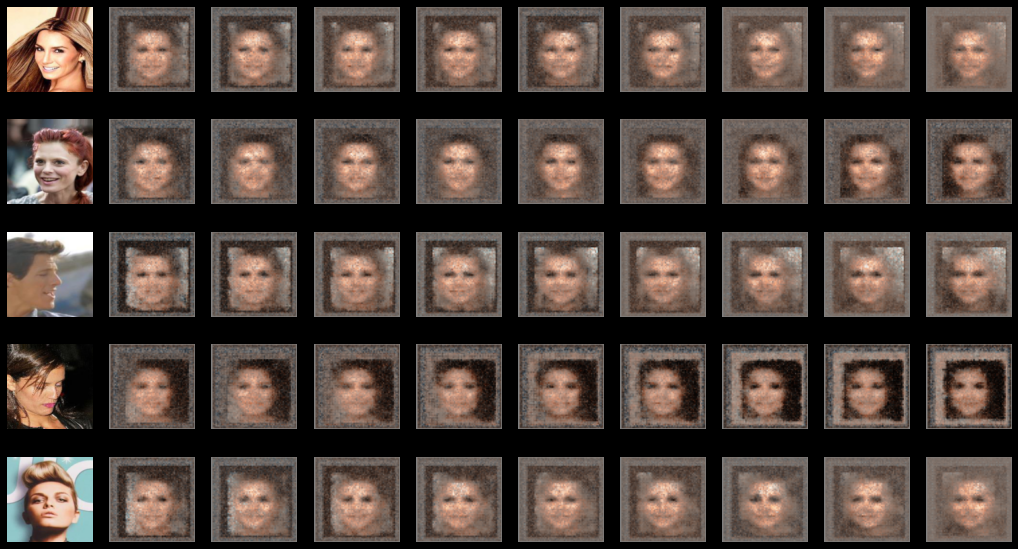

In [102]:
# print('Attractive Vector')
# add_vector_to_images(attractive_vec)

# print('Mouth Open Vector')
# add_vector_to_images(mouth_open_vec)

# print('Smiling Vector')
# add_vector_to_images(smiling_vec)

# print('Lipstick Vector')
# add_vector_to_images(lipstick_vec)

# print('Young Vector')
# add_vector_to_images(young_vec)

# print('Male Vector')
# add_vector_to_images(male_vec)

print('Eyeglasses Vector')
add_vector_to_images(eyeglasses_vec)

# print('Blond Vector')
# add_vector_to_images(blonde_vec)

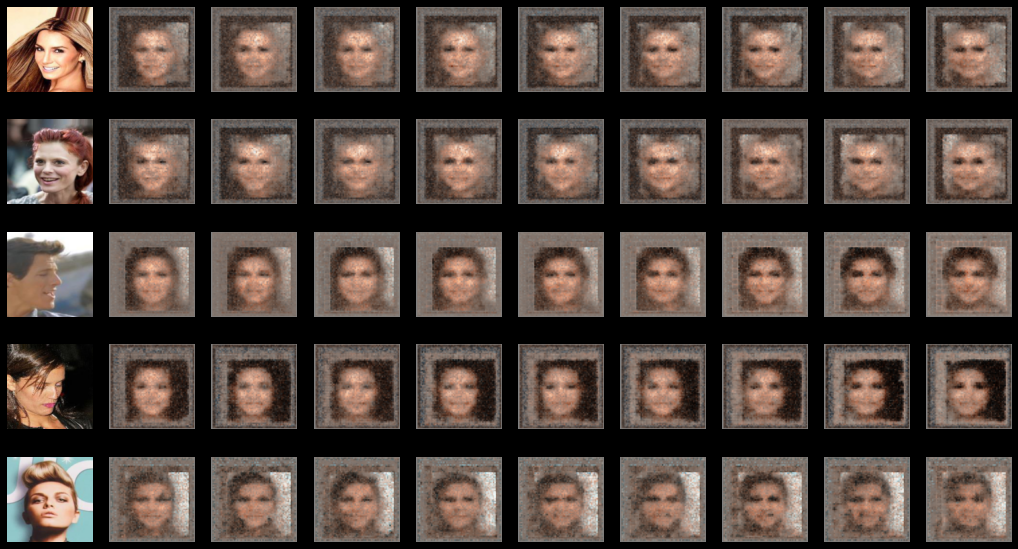

In [103]:
add_vector_to_images(male_vec)

In [122]:

def morph_faces(start_image_file, end_image_file):
    with torch.no_grad():
        transform1 = transforms.ToPILImage()

        factors = np.arange(0,1,0.1)

        att_specific = att[att['image_id'].isin([start_image_file, end_image_file])]
        att_specific = att_specific.reset_index()
        att_specific.pop('index')
        dataloader = DataLoader(SimpleDataset(att_specific, transform), 2)

        example_batch = next(iter(dataloader))
        example_images = example_batch[0]
        example_labels = example_batch[1]

        z_points, _, _ = model.encoder(example_images)


        fig = plt.figure(figsize=(18, 8))

        counter = 1

        img = example_images[0].squeeze()
        sub = fig.add_subplot(1, len(factors)+2, counter)
        sub.axis('off')        
        sub.imshow(transform1(img))

        counter+=1


        for factor in factors:

            changed_z_point = z_points[0] * (1-factor) + z_points[1]  * factor
            changed_image = model.decoder(changed_z_point)

            img = changed_image.squeeze()
            sub = fig.add_subplot(1, len(factors)+2, counter)
            sub.axis('off')
            sub.imshow(transform1(img))

            counter += 1

        img = example_images[1].squeeze()
        sub = fig.add_subplot(1, len(factors)+2, counter)
        sub.axis('off')        
        sub.imshow(transform1(img))


        plt.show()

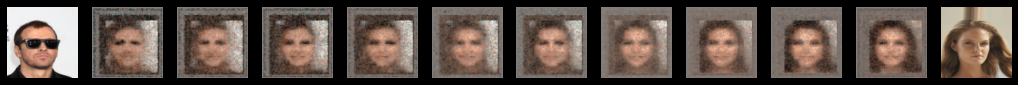

In [123]:
start_image_file = '000238.jpg' 
end_image_file = '000193.jpg' #glasses

morph_faces(start_image_file, end_image_file)

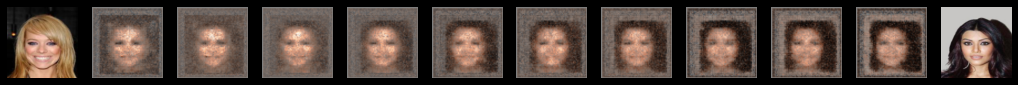

In [124]:
start_image_file = '000112.jpg'
end_image_file = '000258.jpg'

morph_faces(start_image_file, end_image_file)

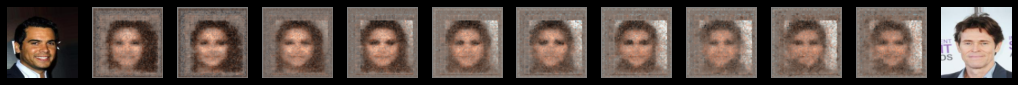

In [125]:
start_image_file = '000230.jpg'
end_image_file = '000712.jpg'

morph_faces(start_image_file, end_image_file)